In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy

c:\Users\surface\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\surface\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
c:\Users\surface\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


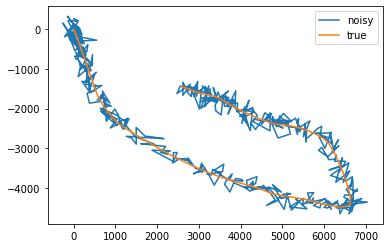

In [16]:
# changing mu/ jump sep generating data
l = 0.05
c = 10
N = 500
T = 1
sigma_w = 0.05
sigma_mu1 = 0.015
sigma_mu2 = 0.015
alpha = 0.9
k_mu1 = sigma_mu1/sigma_w
k_mu2 = sigma_mu2/sigma_w
k_v = 700*4 # 10



def returnQ(delta_t):
    theta = -l
    M1 = np.matrix([[1/theta**2, 1/theta],[1/theta, 1]])
    M2 = np.matrix([[-2/theta**2, -1/theta],[-1/theta, 0]])
    M3 = np.matrix([[1/theta**2,0],[0,0]])
    Q_delta_t1 = (np.exp(2*theta*delta_t)-1)/2/theta*M1+ (np.exp(theta*delta_t)-1)/theta*M2 + delta_t*M3

    Q_delta_t = np.matrix(np.zeros((4,4)))
    Q_delta_t[:2,:2] = Q_delta_t1 * (1+delta_t*k_mu1**2)
    Q_delta_t[2:,2:] = Q_delta_t1 * (1+delta_t*k_mu2**2)

    return Q_delta_t

def simu_langevin_changing_mu():
    x = np.matrix([0,0,0,0]).T # vertical matrix
    x_ns = np.zeros((N,4))
    t_ns = np.zeros(N)
    u_ns = np.zeros((N,2))

    u1 = 0.05 # start of u
    u2 = -0.1
#     u1,u2 = 0, 0

    vs_nt = []
    gammas_nt = []

    for n in range(N):
        gamma = 0
       
        vs = []
        gammas = []
        while gamma<c*T:
            delta_gamma = np.random.exponential(scale = 1.0)
            gamma = gamma+delta_gamma

            v_i = np.random.uniform(0,T)
            while v_i==0:
                v_i = np.random.uniform(0,T) # need to make sure v_i is non-zero
               
            vs.append(v_i)
            gammas.append(gamma)
       
        # sort v, gamma with increasing v
        gammas = [x for _, x in sorted(zip(vs, gammas), key=lambda pair: pair[0])]
        vs.sort()
        gammas_nt.append(gammas)
        vs_nt.append(vs)
        v0 = 0.0
        
        m_c = 0
        S_c = 0
        for v_i, gamma in zip(vs, gammas):
            dt_i = v_i - v0
            # generate u, as a brownian motion
            u1_i = np.random.normal(u1, sigma_mu1*np.sqrt(dt_i))
            u2_i = np.random.normal(u2, sigma_mu2*np.sqrt(dt_i))

            # calculate mean delta t^c      
            f1 = -np.exp(-l*(T-v_i))/l+1/l
            f2 = np.exp(-(T-v_i)*l)
            f_delta_t_v_i_m = np.matrix([f1,f2,f1,f2]).T
            f_delta_t_v_i = np.matrix([[f1,0],[f2,0],[0,f1],[0,f2]])
           
            # mean
            m_c_dt_i = T**(1/alpha)*gamma**(-1/alpha)*f_delta_t_v_i_m
            m_c_dt_i[0:2] *= u1_i
            m_c_dt_i[2:] *= u2_i
            m_c += m_c_dt_i
           
            # variance
            s_c_dt_i = T**(2/alpha)*gamma**(-2/alpha)*np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)
            S_c += s_c_dt_i*sigma_w**2

            # # centering term
            # c1 = -(1-np.exp(-l*dt_i))/l**2 + dt_i/l
            # c2 = (1-np.exp(-l*dt_i))/l
            # Z_c_bar_i = alpha/(alpha-1)*c**(1-1/alpha)* np.matrix([u1_i*c1,u1_i*c2,u2_i*c1,u2_i*c2]).T

            # Q_delta_t = returnQ(dt_i)*sigma_w**2
            # S_delta_t = sigma_w**2*s_c_dt_i # + alpha/(2-alpha)*c**(1-2/alpha)*Q_delta_t

            # updata variables
            u1 = u1_i
            u2 = u2_i
            v0 = v_i

        m12 = -(np.exp(-T*l)-1)/l
        m22 = np.exp(-T*l)
        m_delta_t = np.matmul(np.matrix([[1,m12,0,0],[0,m22,0,0],[0,0,1,m12],[0,0,0,m22]]),x)+m_c
        
        x = np.random.multivariate_normal(np.array(m_delta_t.T)[0], S_c.T) # horizontal array
        x_ns[n,:]=x
        x = np.matrix(x).T # transform x to be a vertical matrix
        t_ns[n]=n*T

        # generate last u_n
        u1 = np.random.normal(u1, sigma_mu1*np.sqrt(T-v0))
        u2 = np.random.normal(u2, sigma_mu2*np.sqrt(T-v0))
        u_ns[n,0] = u1
        u_ns[n,1] = u2

        # Q_delta_t = returnQ(dt_i)*sigma_w**2
        # S_delta_t = alpha/(2-alpha)*c**(1-2/alpha)*Q_delta_t # last dt_i, no jump
       
    return x_ns, t_ns, u_ns, gammas_nt, vs_nt

x_ns, t_ns, u_ns, gammas_nt, vs_nt = simu_langevin_changing_mu()
# add noise
noise_sig = sigma_w*k_v

noise = np.random.normal(0, noise_sig, (N, 4))
y_ns = x_ns+noise # noisy data
y_ns = y_ns[:,(0,2)]

plt.figure()
plt.plot(y_ns[:,0], y_ns[:,1])
plt.plot(x_ns[:,0],x_ns[:,2])
plt.legend(['noisy', 'true'])

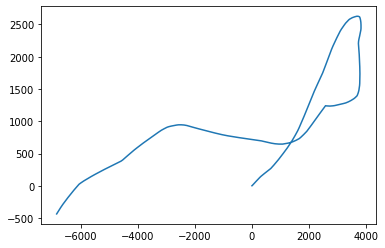

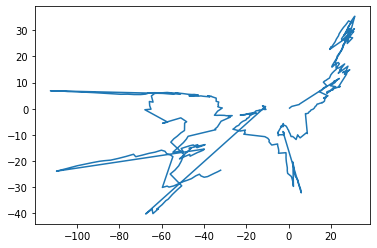

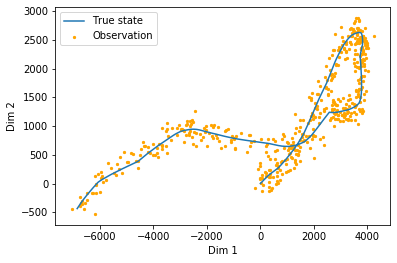

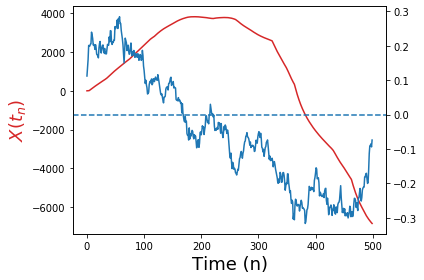

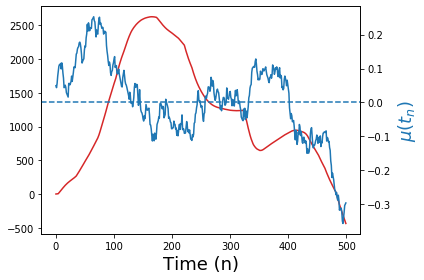

In [129]:
# plot mu with x, see the effect of skewness
fix = 'N500_l005_sigw005_sigmu000015'

plt.figure()
plt.plot(x_ns[:,0], x_ns[:,2])   
# plt.title('displacement') 
plt.savefig(f'trajectory/x{fix}.png')

plt.figure()
plt.plot(x_ns[:,1], x_ns[:,3])   
# plt.title('velocity') 
plt.savefig(f'trajectory/v{fix}.png')

plt.figure()
plt.plot(x_ns[:,0],x_ns[:,2])
plt.scatter(y_ns[:,0], y_ns[:,1], color='orange',s=5)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.legend(['True state','Observation'])
plt.savefig(f'trajectory/noisy_x_{fix}.png')

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Time (n)', fontsize='18')
ax1.set_ylabel('$X(t_n)$', color=color, fontsize='18')
ax1.plot(x_ns[:,0], color=color)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
# ax2.set_ylabel('mean of noise, x', color=color)  # we already handled the x-label with ax1
ax2.plot(u_ns[:,0], color=color)
ax2.tick_params(axis='y')
ax2.axhline(y=0.0,linestyle='dashed',)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig(f'trajectory/x_mu_x_{fix}.png')

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Time (n)', fontsize='18')
# ax1.set_ylabel('displacement, x', color=color)
ax1.plot(x_ns[:,2], color=color)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('$\mu(t_n)$', color=color, fontsize='18')  # we already handled the x-label with ax1
ax2.plot(u_ns[:,1], color=color)
ax2.tick_params(axis='y')
ax2.axhline(y=0.0,linestyle='dashed',)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig(f'trajectory/x_mu_y_{fix}.png')


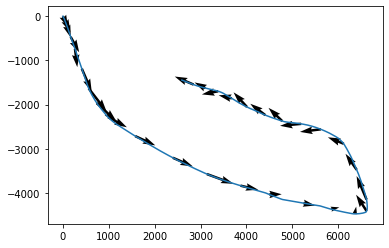

In [17]:
fix = 'N500_l005_sigw005_sigmu0015_mu005__01'
plt.figure()
idxes = np.linspace(0,500,endpoint=False, num=30, dtype=np.int32)
plt.plot(x_ns[:,0], x_ns[:,2])  
plt.quiver(x_ns[idxes,0],x_ns[idxes,2], u_ns[idxes,0], u_ns[idxes,1])
# plt.legend(['$X(t)$','$\mu(t)$'])
# plt.xlabel('Dim 1')
# plt.ylabel('Dim 2')
plt.savefig(f'trajectory/x_mu_2D_{fix}_nolabel.png')

In [23]:
# jump sep
alpha_w = 0.000000000001
beta_w = 0.000000000001

def construct_A(e_Adt, m_c_y_c):
    # construct A
    A = np.matrix(np.zeros((6,6)))
    A[:4,:4] = e_Adt
    A[0,4] = m_c_y_c[0]
    A[1,4] = m_c_y_c[1]
    A[2,5] = m_c_y_c[2]
    A[3,5] = m_c_y_c[3]
    A[4:,4:] = np.identity(2)
    return A


def sampling_latent_variables(delta_t, sigma_w, alpha, gammas, vis):
    m_c_dt = 0
    s_c_dt = 0
    
    theta = -l
    M1 = np.matrix([[1/theta**2, 1/theta],[1/theta, 1]])
    M2 = np.matrix([[-2/theta**2, -1/theta],[-1/theta, 0]])
    M3 = np.matrix([[1/theta**2,0],[0,0]])
    Q_delta_t1 = (np.exp(2*theta*delta_t)-1)/2/theta*M1+ (np.exp(theta*delta_t)-1)/theta*M2 + delta_t*M3
    
    Q_delta_t = np.matrix(np.zeros((4,4)))
    Q_delta_t[:2,:2] = Q_delta_t1
    Q_delta_t[2:,2:] = Q_delta_t1

    for gamma, v_i in zip(gammas, vis):
        # calculate mean delta t^c      
        f1 = -np.exp(-l*(delta_t-v_i))/l+1/l
        f2 = np.exp(-(delta_t-v_i)*l)
        f_delta_t_v_i_m = np.matrix([f1,f2,f1,f2]).T
        f_delta_t_v_i = np.matrix([[f1,0],[f2,0],[0,f1],[0,f2]])
        m_c_dt += delta_t**(1/alpha)*gamma**(-1/alpha)*f_delta_t_v_i_m
        s_c_dt += delta_t**(2/alpha)*gamma**(-2/alpha)*np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)

    S_delta_t = s_c_dt # + alpha/(2-alpha)*c**(1-2/alpha)*Q_delta_t # C_e
    S_delta_t *= sigma_w**2
    
    m12 = -(np.exp(-delta_t*l)-1)/l
    m22 = np.exp(-delta_t*l)
    # centering term
    c1 = -(1-np.exp(-l*delta_t))/l**2 + delta_t/l
    c2 = (1-np.exp(-l*delta_t))/l
    if alpha>1:
        Z_c_bar_divMu = alpha/(alpha-1)*c**(1-1/alpha)* np.matrix([c1,c2,c1,c2]).T # Y_c
    else:
        Z_c_bar_divMu = 0
    
    e_Adt = np.matrix([[1,m12,0,0],[0,m22,0,0],[0,0,1,m12],[0,0,0,m22]])
    m_c_y_c=m_c_dt - Z_c_bar_divMu
    
    A = construct_A(e_Adt, m_c_y_c)
    B = np.matrix(np.zeros((6,4)))
    B[:4,:4] = np.identity(4)
    
    return A, B, S_delta_t

def prediction_step(v_i, gamma, T, delta_t):
    # calculate mean delta t^c      
    f1 = -np.exp(-l*(v_i-v_i))/l+1/l
    f2 = np.exp(-(v_i-v_i)*l)
    f_delta_t_v_i_m = np.matrix([f1,f2,f1,f2]).T
    f_delta_t_v_i = np.matrix([[f1,0],[f2,0],[0,f1],[0,f2]])
    if gamma == 0:
        m_c_y_c = np.matrix([0.0,0.0,0.0,0.0]).T
        s_c_dt = 0.0 * np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)
    else:
        m_c_y_c = T**(1/alpha)*gamma**(-1/alpha)*f_delta_t_v_i_m
        s_c_dt = T**(2/alpha)*gamma**(-2/alpha)*np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)

    Q_delta_t = returnQ(delta_t)
    C_e = s_c_dt # + alpha/(2-alpha)*c**(1-2/alpha)*Q_delta_t # C_e

    m12 = -(np.exp(-delta_t*l)-1)/l
    m22 = np.exp(-delta_t*l)
    e_Adt = np.matrix([[1,m12,0,0],[0,m22,0,0],[0,0,1,m12],[0,0,0,m22]])

    c1 = -(1-np.exp(-l*delta_t))/l**2 + delta_t/l
    c2 = (1-np.exp(-l*delta_t))/l
#     Z_c_bar = alpha/(alpha-1)*c**(1-1/alpha)* np.matrix([mu_w1*c1,mu_w1*c2,mu_w2*c1,mu_w2*c2]).T
    if alpha>1:
        Z_c_bar_divMu = alpha/(alpha-1)*c**(1-1/alpha)* np.matrix([c1,c2,c1,c2]).T # Y_c
    else:
        Z_c_bar_divMu = 0.0* np.matrix([c1,c2,c1,c2]).T
    m_c_y_c-=Z_c_bar_divMu

    # construct A
    A = construct_A(e_Adt, m_c_y_c)
    C_e_full = np.matrix(np.zeros((6,6)))
    C_e_full[:4,:4] = C_e*sigma_w**2
    C_e_full[4,4] = sigma_mu1**2*delta_t
    C_e_full[5,5] = sigma_mu2**2*delta_t
    B = np.identity(6)

    return A, B, C_e_full

def sampling_latent_variables_para(T, alpha, mu_p, P_p, gammas, vs):
    # gammas = []
    # vs = []
    
    # gamma = 0
    # while gamma<c*T:
    #     delta_gamma = np.random.exponential(scale = 1.0)
    #     gamma = gamma+delta_gamma
        
    #     v_i = np.random.uniform(0,T)
    #     while v_i==0:
    #         v_i = np.random.uniform(0,T) # need to make sure v_i is non-zero

    #     gammas.append(gamma)
    #     vs.append(v_i)

    # order jumps
    gammas = [x for _,x in sorted(zip(vs, gammas))]
    vs.sort()

    # # compare this with estimating together
    # A, B, C_e = sampling_latent_variables(T, sigma_w, alpha, gammas, vs)
    # mu_n_prev_n = A*mu_p
    # P_n_prev_n = A*P_p*A.T + B* C_e*B.T

    # return mu_n_prev_n, P_n_prev_n

    v0 = 0.0
    for v_i, gamma in zip(vs, gammas):
        # prediction step repeatedly
        delta_t = v_i - v0
        v0 = v_i

        A, B, C_e = prediction_step(v_i, gamma, T, delta_t)

        mu_p = A*mu_p
        P_p = A*P_p*A.T + B* C_e*B.T

    # final step, zero jump
    delta_t = T -v0
    A, B, C_e = prediction_step(v_i, 0.0, T, delta_t)
    mu_p = A*mu_p
    P_p = A*P_p*A.T + B* C_e*B.T
    
    return mu_p, P_p


def single_ite_particle_filtering_para(y_n, log_weight_p, mu_p, P_p, E_ns, gammas, vs, n, sigma_mus, sigma_w, noise_sig, resample = False):
    # mu_p = [mu1, mu2, .. muP], P_p = [P1, P2, .. PP]
    num_particles = len(mu_p) # list of list of lists, because length if each particle is not fixed, P*n*I
    if resample:
        indices = np.random.choice(list(range(num_particles)), size = num_particles, p = np.exp(log_weight_p))
        mu_p = [mu_p[i] for i in indices]
        P_p = [P_p[i] for i in indices]
        # todo: E resample
        E_ns = [E_ns[i,:] for i in indices]
        E_ns = np.array(E_ns)
        
#         weight_p = np.ones(num_particles)*(1/num_particles)
        log_weight_p = np.log(np.ones(num_particles)*(1/num_particles))
    
    C = np.matrix(np.zeros((2,6)))
    C[0,0] = 1
    C[1,2] = 1 # observation matrix
    R = np.matrix(np.zeros)
    R = np.identity(2)*noise_sig**2
    
    mu_p_nextn = []
    P_p_nextn = []
    log_weights_p_nextn = np.ones(num_particles)
    for p in range(num_particles):
        mu_n_prev_n, P_n_prev_n = sampling_latent_variables_para(1, alpha, mu_p[p], P_p[p], gammas, vs)

        y_hat_n_prev_n = C*mu_n_prev_n
        sigma_n_prev_n = C*P_n_prev_n*C.T + R
        K = P_n_prev_n*C.T*np.linalg.inv(sigma_n_prev_n)
        mu_n_n = mu_n_prev_n+K*(y_n-y_hat_n_prev_n)
        P_n_n = (np.identity(6) - K*C)*P_n_prev_n

        mu_p_nextn.append(mu_n_n)
        P_p_nextn.append(P_n_n)

#         w_p_nextn = weight_p[p]*stats.multivariate_normal(np.array(mu_n_n.T)[0], P_n_n).pdf(np.array(y_n.T)[0])
#         weights_p_nextn[p] = w_p_nextn
        # count sigma_w in, n in 1:N
        norm_sigma_n_prev_n = sigma_n_prev_n/sigma_w**2
        E_ns[p,n] = -(y_n-y_hat_n_prev_n).T*np.linalg.inv(norm_sigma_n_prev_n)*(y_n-y_hat_n_prev_n)/2
        beta_w_post_p = beta_w - sum(E_ns[p,:(n+1)]) # current point
        log_like = -0.5*np.log(np.linalg.det(sigma_n_prev_n))-(alpha_w+n*2/2)*np.log(beta_w_post_p)\
                    +((n-1)*2/2+alpha_w)*np.log(beta_w - sum(E_ns[p,:n]))+\
                    scipy.special.loggamma(n*2/2+alpha_w)-scipy.special.loggamma((n-1)*2/2+alpha_w) # -2/2*np.log(2*np.pi)
    
        # normalise weights
        # log_like = -(y_n-y_hat_n_prev_n).T*np.linalg.inv(sigma_n_prev_n)*(y_n-y_hat_n_prev_n)/2-0.5*np.log(np.linalg.det(sigma_n_prev_n))-2/2*np.log(2*np.pi)
        log_w_p_nextn = log_weight_p[p]+log_like
#         log_w_p_nextn = log_weight_p[p]+np.log(stats.multivariate_normal(np.array(y_hat_n_prev_n.T)[0], sigma_n_prev_n).pdf(np.array(y_n.T)[0]))
        log_weights_p_nextn[p] = log_w_p_nextn 
    
    # normalise weights
    try:
        log_weights_p_nextn = log_weights_p_nextn-np.log(sum(np.exp(log_weights_p_nextn)))
    except:
        import pdb;pdb.set_trace()
#     weights_p_nextn = weights_p_nextn/sum(weights_p_nextn)
    
    return log_weights_p_nextn, mu_p_nextn, P_p_nextn, E_ns

In [24]:
# jump together
from func import construct_Cmu, dim1todim2, dim2todim1, constructA2Ce

sigma_mus = [sigma_mu1, sigma_mu2]
def sampling_latent_variables_para(T, alpha, mu_p, P_p, gammas, vs):
    # gammas = []
    # vs = []
    
    # gamma = 0
    # while gamma<c*T:
    #     delta_gamma = np.random.exponential(scale = 1.0)
    #     gamma = gamma+delta_gamma
        
    #     v_i = np.random.uniform(0,T)
    #     while v_i==0:
    #         v_i = np.random.uniform(0,T) # need to make sure v_i is non-zero

    #     gammas.append(gamma)
    #     vs.append(v_i)

    # order jumps
    gammas = [x for _,x in sorted(zip(vs, gammas))]
    vs.sort()

    A1 = np.zeros((3+len(vs),3))
    A1[:2,:2] = np.identity(2)
    A1[2:, 2] += 1
    B1 = np.zeros((3+len(vs), 1+len(vs)))
    B1[2:,:] = np.identity(1+len(vs))
    B2 = np.zeros((3,2))
    B2[:2,:2]=np.identity(2)

    mu_ps, P_ps = dim2todim1(mu_p, P_p)

    for d in range(2):
        # iterate through all dimensions
        Ce1 = construct_Cmu(vs, sigma_mus[d], T)
        mu_p1d = mu_ps[d]
        P_p1d = P_ps[d]

        mu_p1d = A1*mu_p1d
        P_p1d = A1*P_p1d*A1.T + B1* Ce1*B1.T

        A2, Ce2 = constructA2Ce(vs, gammas, T, l, alpha,c)
        Ce2 *= sigma_w**2 # assume known sigma_w
        mu_p1d = A2*mu_p1d
        P_p1d = A2*P_p1d*A2.T + B2* Ce2*B2.T

        mu_ps[d]=mu_p1d
        P_ps[d] = P_p1d
    
    mu_p, P_p = dim1todim2(mu_ps, P_ps)
    # print(mu_p, P_p)
    
    return mu_p, P_p

def single_ite_particle_filtering_bytimestep(y_n, log_weight_p, mu_p, P_p, E_ns, gammas, vs, n, sigma_mus, sigma_w, noise_sig, resample = False):
    # mu_p = [mu1, mu2, .. muP], P_p = [P1, P2, .. PP]
    num_particles = len(mu_p) # list of list of lists, because length if each particle is not fixed, P*n*I
    if resample:
        indices = np.random.choice(list(range(num_particles)), size = num_particles, p = np.exp(log_weight_p))
        mu_p = [mu_p[i] for i in indices]
        P_p = [P_p[i] for i in indices]
        E_ns = [E_ns[i,:] for i in indices]
        E_ns = np.array(E_ns)
        
#         weight_p = np.ones(num_particles)*(1/num_particles)
        log_weight_p = np.log(np.ones(num_particles)*(1/num_particles))
    
    C = np.matrix(np.zeros((2,6)))
    C[0,0] = 1
    C[1,2] = 1 # observation matrix
    R = np.matrix(np.zeros)
    R = np.identity(2)*noise_sig**2
    
    mu_p_nextn = []
    P_p_nextn = []
    log_weights_p_nextn = np.ones(num_particles)
    for p in range(num_particles):
        mu_n_prev_n, P_n_prev_n = sampling_latent_variables_para(1, alpha, mu_p[p], P_p[p], gammas, vs)

        y_hat_n_prev_n = C*mu_n_prev_n
        sigma_n_prev_n = C*P_n_prev_n*C.T + R
        K = P_n_prev_n*C.T*np.linalg.inv(sigma_n_prev_n)
        mu_n_n = mu_n_prev_n+K*(y_n-y_hat_n_prev_n)
        P_n_n = (np.identity(6) - K*C)*P_n_prev_n

        mu_p_nextn.append(mu_n_n)
        P_p_nextn.append(P_n_n)

#         w_p_nextn = weight_p[p]*stats.multivariate_normal(np.array(mu_n_n.T)[0], P_n_n).pdf(np.array(y_n.T)[0])
#         weights_p_nextn[p] = w_p_nextn
        # count sigma_w in
        norm_sigma_n_prev_n = sigma_n_prev_n/sigma_w**2
        E_ns[p,n] = -(y_n-y_hat_n_prev_n).T*np.linalg.inv(norm_sigma_n_prev_n)*(y_n-y_hat_n_prev_n)/2
        beta_w_post_p = beta_w - sum(E_ns[p,:])
        log_like = -0.5*np.log(np.linalg.det(sigma_n_prev_n))-(alpha_w+n*2/2)*np.log(beta_w_post_p)\
                    +((n-1)*2/2+alpha_w)*np.log(beta_w - sum(E_ns[p,:n]))+\
                    scipy.special.loggamma(n*2/2+alpha_w)-scipy.special.loggamma((n-1)*2/2+alpha_w) # -2/2*np.log(2*np.pi)
    
        # normalise weights
        # log_like = -(y_n-y_hat_n_prev_n).T*np.linalg.inv(sigma_n_prev_n)*(y_n-y_hat_n_prev_n)/2-0.5*np.log(np.linalg.det(sigma_n_prev_n))-2/2*np.log(2*np.pi)
        log_w_p_nextn = log_weight_p[p]+log_like
#         log_w_p_nextn = log_weight_p[p]+np.log(stats.multivariate_normal(np.array(y_hat_n_prev_n.T)[0], sigma_n_prev_n).pdf(np.array(y_n.T)[0]))
        log_weights_p_nextn[p] = log_w_p_nextn 
    
    # normalise weights
    try:
        log_weights_p_nextn = log_weights_p_nextn-np.log(sum(np.exp(log_weights_p_nextn)))
    except:
        import pdb;pdb.set_trace()
#     weights_p_nextn = weights_p_nextn/sum(weights_p_nextn)
    
    return log_weights_p_nextn, mu_p_nextn, P_p_nextn, E_ns

In [25]:
# jump together, single step
from func import dim1todim2, dim2todim1
def constructA12B12(vs, gammas, T,l,alpha,sigma_w, sigma_mu):
    # A
    A = np.matrix(np.zeros((3,3)))
    m12 = -(np.exp(-T*l)-1)/l
    m22 = np.exp(-T*l)
    A[:2,:2] = np.matrix([[1,m12],[0,m22]])

    S_c = 0
    m_c = np.matrix(np.zeros((2,len(vs)+1)))
    m_c_sum = 0
    for i in range(len(vs)):
        v_i = vs[i]
        gamma = gammas[i]
        # calculate mean delta t^c      
        f1 = -np.exp(-l*(T-v_i))/l+1/l
        f2 = np.exp(-(T-v_i)*l)
        f_delta_t_v_i = np.matrix([f1,f2]).T

        m_c_dt_i = T**(1/alpha)*gamma**(-1/alpha)*f_delta_t_v_i
        m_c_sum += m_c_dt_i
        m_c[:,i] = m_c_dt_i
        
        # variance
        s_c_dt_i = T**(2/alpha)*gamma**(-2/alpha)*np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)
        S_c += s_c_dt_i*sigma_w**2

    A[:2,2] = m_c_sum
    A[2,2] = 1

    # B
    B = np.matrix(np.zeros((3,len(vs)+3)))
    B[:2,:len(vs)+1] = m_c
    B[:2,len(vs)+1:] = np.identity(2)
    B[2,len(vs)] = 1

    # C
    C = np.matrix(np.zeros((len(vs)+3,len(vs)+3)))
    C[:len(vs)+1, :len(vs)+1] = construct_Cmu(vs, sigma_mu, T)
    C[len(vs)+1:, len(vs)+1:] = S_c

    return A, B, C

def sampling_latent_variables_para(T, alpha, mu_p, P_p, gammas, vs, sigma_mus, sigma_w):
    gammas = []
    vs = []
    
    gamma = 0
    while gamma<c*T:
        delta_gamma = np.random.exponential(scale = 1.0)
        gamma = gamma+delta_gamma
        
        v_i = np.random.uniform(0,T)
        while v_i==0:
            v_i = np.random.uniform(0,T) # need to make sure v_i is non-zero

        gammas.append(gamma)
        vs.append(v_i)

    # order jumps
    gammas = [x for _,x in sorted(zip(vs, gammas))]
    vs.sort()

    mu_ps, P_ps = dim2todim1(mu_p, P_p)

    for d in range(2):
        # iterate through all dimensions
        A,B,C = constructA12B12(vs,gammas,T,l, alpha, sigma_w, sigma_mus[d])
        mu_p1d = mu_ps[d]
        P_p1d = P_ps[d]

        mu_p1d = A*mu_p1d
        P_p1d = A*P_p1d*A.T + B* C*B.T

        mu_ps[d]=mu_p1d
        P_ps[d] = P_p1d
    
    mu_p, P_p = dim1todim2(mu_ps, P_ps)
    
    return mu_p, P_p

def single_ite_particle_filtering_bytimestep(y_n, log_weight_p, mu_p, P_p, E_ns, gammas, vs, n, sigma_mus, sigma_w, noise_sig, resample = False, ):
    # mu_p = [mu1, mu2, .. muP], P_p = [P1, P2, .. PP]
    num_particles = len(mu_p) # list of list of lists, because length if each particle is not fixed, P*n*I
    if resample:
        indices = np.random.choice(list(range(num_particles)), size = num_particles, p = np.exp(log_weight_p))
        mu_p = [mu_p[i] for i in indices]
        P_p = [P_p[i] for i in indices]
        E_ns = [E_ns[i,:] for i in indices]
        E_ns = np.array(E_ns)
        
        log_weight_p = np.log(np.ones(num_particles)*(1/num_particles))
    
    C = np.matrix(np.zeros((2,6)))
    C[0,0] = 1
    C[1,2] = 1 # observation matrix
    R = np.matrix(np.zeros)
    R = np.identity(2) *noise_sig**2
    
    mu_p_nextn = []
    P_p_nextn = []
    log_weights_p_nextn = np.ones(num_particles)
    for p in range(num_particles):
        mu_n_prev_n, P_n_prev_n = sampling_latent_variables_para(T, alpha, mu_p[p], P_p[p], gammas, vs, sigma_mus, sigma_w)

        y_hat_n_prev_n = C*mu_n_prev_n
        sigma_n_prev_n = C*P_n_prev_n*C.T + R
        K = P_n_prev_n*C.T*np.linalg.inv(sigma_n_prev_n)
        mu_n_n = mu_n_prev_n+K*(y_n-y_hat_n_prev_n)
        P_n_n = (np.identity(6) - K*C)*P_n_prev_n

        mu_p_nextn.append(mu_n_n)
        P_p_nextn.append(P_n_n)

        # count sigma_w in
        norm_sigma_n_prev_n = sigma_n_prev_n /sigma_w**2
        E_ns[p,n] = -(y_n-y_hat_n_prev_n).T*np.linalg.inv(norm_sigma_n_prev_n)*(y_n-y_hat_n_prev_n)/2
        beta_w_post_p = beta_w - sum(E_ns[p,:])
        log_like = -0.5*np.log(np.linalg.det(sigma_n_prev_n))-(alpha_w+n*2/2)*np.log(beta_w_post_p)\
                    +((n-1)*2/2+alpha_w)*np.log(beta_w - sum(E_ns[p,:n]))+\
                    scipy.special.loggamma(n*2/2+alpha_w)-scipy.special.loggamma((n-1)*2/2+alpha_w) # -2/2*np.log(2*np.pi)
    
        # normalise weights
        # log_like = -(y_n-y_hat_n_prev_n).T*np.linalg.inv(sigma_n_prev_n)*(y_n-y_hat_n_prev_n)/2-0.5*np.log(np.linalg.det(sigma_n_prev_n))-2/2*np.log(2*np.pi)
        log_w_p_nextn = log_weight_p[p]+log_like
#         log_w_p_nextn = log_weight_p[p]+np.log(stats.multivariate_normal(np.array(y_hat_n_prev_n.T)[0], sigma_n_prev_n).pdf(np.array(y_n.T)[0]))
        log_weights_p_nextn[p] = log_w_p_nextn 
    
    # normalise weights
    try:
        log_weights_p_nextn = log_weights_p_nextn-np.log(sum(np.exp(log_weights_p_nextn)))
    except:
        import pdb;pdb.set_trace()
#     weights_p_nextn = weights_p_nextn/sum(weights_p_nextn)
    
    return log_weights_p_nextn, mu_p_nextn, P_p_nextn, E_ns

In [103]:
# particle filter

# sigma_mus_norm = [sigma_mu1/sigma_w, sigma_mu2/sigma_w] # normalise noise term
# sigma_w_norm = 1
# noise_norm = noise_sig/sigma_w

n_mus = []
n_Ps = []
n_ws = []
num_particles = 300

# initialize x
mu_p_1 = np.matrix(np.zeros(6)).T
# mu_p_1[4:,0] = np.matrix([[mu_w1],[mu_w1]])
mu_p = [mu_p_1]*num_particles
P_p = [np.matrix(np.identity(6))*10]*num_particles
log_weight_p = np.log(np.ones(num_particles)*(1/num_particles))

E_ns = np.zeros((num_particles, N+1)) # store exp likelihood of y

for n in range(N):
    y_n = np.matrix(y_ns[n]).T

    gammas = gammas_nt[n]
    vs = vs_nt[n]

    # if n%5 == 0:
    #     resample = True
    # else:
    #     resample = False
    resample = True
    log_weight_p, mu_p, P_p, E_ns = single_ite_particle_filtering_bytimestep(y_n, log_weight_p, mu_p, P_p, E_ns, gammas, vs, n+1, sigma_mus, sigma_w, noise_sig, resample = resample)
    
    n_mus.append(mu_p)
    n_Ps.append(P_p)
    n_ws.append(log_weight_p)

n_mus = np.array(n_mus)
n_Ps = np.array(n_Ps)
n_Ps /= sigma_w**2 # if marginalizing sigma
n_ws = np.array(n_ws)

In [104]:
# examine data
average = np.zeros((N, 6))
std3 = np.zeros((N, 6))
avg_P = np.zeros((N, 6, 6))

mean_sigmas = np.zeros((N,num_particles))
var_sigmas = np.zeros((N,num_particles))
betas = np.zeros((N, num_particles))
for n in range(N):
    alpha_n = alpha_w + (n+1)
    for p in range(num_particles):
        betas[n,p] = beta_w - sum(E_ns[p,:(n+2)])
        mean_sigmas[n,p] = betas[n,p]/(alpha_n-1)
        var_sigmas[n,p] = max(0, betas[n,p]**2/(alpha_n-1)**2/(alpha_n-2))

tot_mean_sigma = np.zeros(N)
tot_var_sigma = np.zeros(N)

for i in range(N):
    alpha_n = alpha_w + (i+1)
    for d in range(6):
        average[i,d]=np.dot(np.array(n_mus[i,:,d,:].T)[0], np.exp(n_ws[i,:]))
        for j in range(6):
            if i<=2:
                var_x_ij = n_Ps[i,:,d,j]*sigma_w**2
            else:
                var_x_ij = n_Ps[i,:,d,j]*betas[i,:]/(alpha_n-1)
            avg_P[i,d,j] = np.dot(np.array(var_x_ij.T), np.exp(n_ws[i,:]))+\
            np.dot((np.array(n_mus[i,:,d,:].T)[0]-average[i,d])*(np.array(n_mus[i,:,j,:].T)[0]-average[i,j]), np.exp(n_ws[i,:]))
            
        std3[i,d]=np.sqrt(avg_P[i,d,d])*3

    tot_mean_sigma[i]=np.dot(mean_sigmas[i,:], np.exp(n_ws[i,:]))
    tot_var_sigma[i] = np.dot(var_sigmas[i,:], np.exp(n_ws[i,:])) + np.dot((mean_sigmas[i,:]-tot_mean_sigma[i])*(mean_sigmas[i,:]-tot_mean_sigma[i]),np.exp(n_ws[i,:]))



10103.338819474786


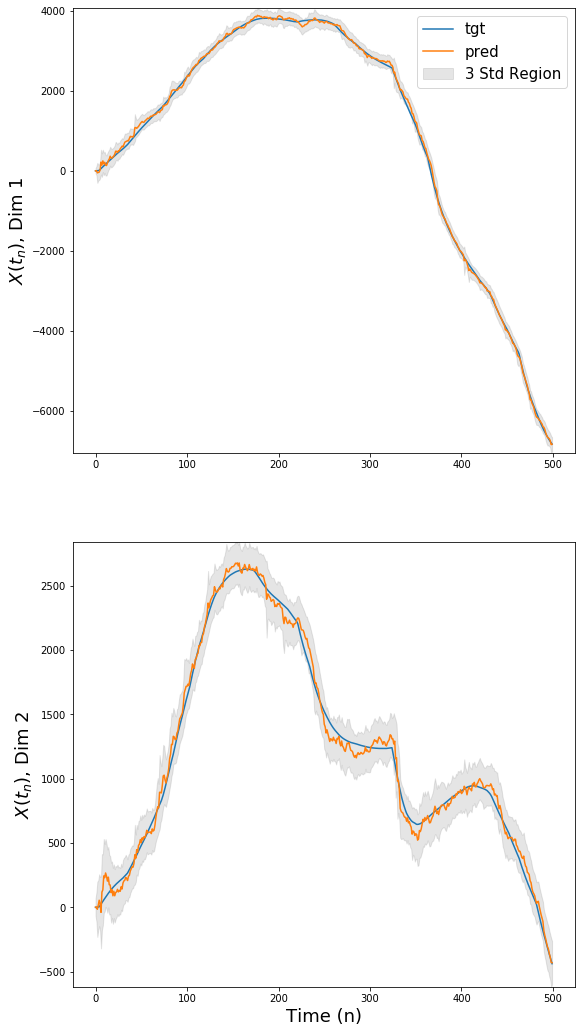

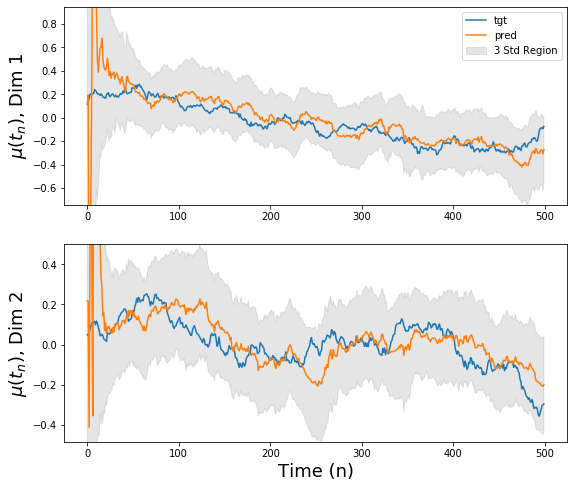

In [139]:
# plot x region
n1 = 0
n2 = N
dim = 0
plt.figure(figsize=(9,18))
plt.subplot(2,1,1)
plt.ylim([min(average[n1:n2,dim] - std3[n1:n2,dim]),max(average[n1:n2,dim] + std3[n1:n2,dim])])
plt.plot(np.linspace(n1,n2,endpoint=False,num=n2-n1),x_ns[n1:n2,0])
plt.plot(np.linspace(n1,n2,endpoint=False,num=n2-n1),average[n1:n2,dim])
plt.fill_between(np.linspace(n1,n2,endpoint=False,num=n2-n1),average[n1:n2,dim] - std3[n1:n2,dim], average[n1:n2,dim] + std3[n1:n2,dim],
                 color='gray', alpha=0.2)
plt.legend(['tgt','pred','3 Std Region'], fontsize = '15')
plt.ylabel('$X(t_n)$, Dim 1', fontsize='18')
# plt.title(f'Jumps separate, alpha = {alpha}, num = {num_particles}')

dim = 2
plt.subplot(2,1,2)
plt.ylim([min(average[n1:n2,dim] - std3[n1:n2,dim]),max(average[n1:n2,dim] + std3[n1:n2,dim])])
plt.plot(np.linspace(n1,n2,endpoint=False,num=n2-n1),x_ns[n1:n2,2])
plt.plot(np.linspace(n1,n2,endpoint=False,num=n2-n1),average[n1:n2,dim])
plt.fill_between(np.linspace(n1,n2,endpoint=False,num=n2-n1),average[n1:n2,dim] - std3[n1:n2,dim], average[n1:n2,dim] + std3[n1:n2,dim],
                 color='gray', alpha=0.2)
plt.ylabel('$X(t_n)$, Dim 2', fontsize='18')
plt.xlabel('Time (n)', fontsize='18')

plt.savefig(f'predictmu/{fix}wSig_X_full.png')

# plot error region
dim = 4
plt.figure(figsize=(9,8))
plt.subplot(2,1,1)
plt.ylim([min(average[25:,dim] - std3[25:,dim]),max(average[25:,dim] + std3[25:,dim])])
plt.plot(u_ns[:,0])
plt.plot(average[:,dim])
plt.fill_between(range(N),average[:,dim] - std3[:,dim], average[:,dim] + std3[:,dim],
                 color='gray', alpha=0.2)
plt.legend(['tgt','pred','3 Std Region'])
plt.ylabel('$\mu(t_n)$, Dim 1', fontsize='18')
# plt.title(f'Jumps separate, alpha = {alpha}, num = {num_particles}')

dim = 5
plt.subplot(2,1,2)
plt.ylim([min(average[25:,dim] - std3[25:,dim]),max(average[25:,dim] + std3[25:,dim])])
plt.plot(u_ns[:,1])
plt.plot(average[:,dim])
plt.fill_between(range(N),average[:,dim] - std3[:,dim], average[:,dim] + std3[:,dim],
                 color='gray', alpha=0.2)
plt.ylabel('$\mu(t_n)$, Dim 2', fontsize='18')
plt.xlabel('Time (n)', fontsize='18')
# plt.legend(['tgt','pred','3 Std Region'])
# plt.savefig(f'predictmu/{fix}wSig.png')

error = sum((average[:-1,0]-x_ns[1:,0])**2+(average[:-1,2]-x_ns[1:,2])**2)/N
print(error)

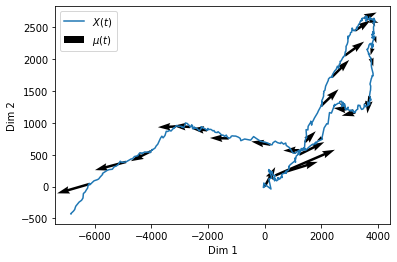

In [148]:
plt.figure()
idxes = np.linspace(0,500,endpoint=False, num=30, dtype=np.int32)
plt.plot(average[:,0], average[:,2])  
plt.quiver(average[idxes,0],average[idxes,2], average[idxes,4], average[idxes,5])
plt.legend(['$X(t)$','$\mu(t)$'])
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.savefig(f'trajectory/x_mu_2D_pred_{fix}.png')

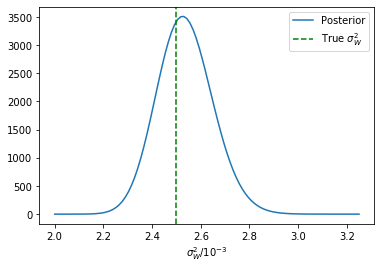

In [107]:
from scipy.stats import invgamma
# plot posterior of sigma
# step 1: get beta from E
alpha = alpha_w + N
xs = np.linspace(sigma_w**2*0.8,sigma_w**2*1.3,100)
fxs = 0
dim = -1
for p in range(num_particles):
    x_beta = xs/betas[-1,p]
    pdf = invgamma.pdf(x_beta, alpha)/betas[-1,p]*np.exp(n_ws[-1,p])
    fxs += pdf

plt.plot(xs*1e3, fxs)
plt.axvline(x = sigma_w**2*1e3, color = 'g', label = '$\sigma_W^2$',linestyle='dashed',)
plt.xlabel(r'$\sigma_W^2 / 10^{-3}$')
plt.legend(['Posterior','True $\sigma_W^2$'])
# plt.savefig(f'predictmu/sigma_{fix}.png')


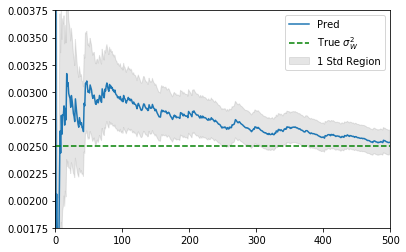

In [108]:

plt.plot(tot_mean_sigma[:])

plt.ylim([0.0,sigma_w**2*2])
plt.axhline(y=sigma_w**2, color = 'g',linestyle='dashed')
plt.fill_between(range(N),tot_mean_sigma[:] - 1*np.sqrt(tot_var_sigma[:]), tot_mean_sigma[:] + 1*np.sqrt(tot_var_sigma[:]),
                 color='gray', alpha=0.2)
plt.legend(['Pred','True $\sigma_W^2$','1 Std Region'])
plt.xlabel('')
plt.xlim([0,N])
plt.ylim([sigma_w**2*0.7,sigma_w**2*1.5])
# plt.savefig(f'predictmu/sigma_ns_{fix}.png')

In [220]:
# 2d tracking const mu
delta_t = T
alpha_w = 0.000000000001
beta_w = 0.000000000001

def sampling_latent_variables_para(delta_t, sigma_w, alpha, s_n, m_n):
    gammas = []
    vs = []
    
    gamma = 0
    m_c_dt = 0
    s_c_dt = 0
    
    theta = -l
    M1 = np.matrix([[1/theta**2, 1/theta],[1/theta, 1]])
    M2 = np.matrix([[-2/theta**2, -1/theta],[-1/theta, 0]])
    M3 = np.matrix([[1/theta**2,0],[0,0]])
    Q_delta_t1 = (np.exp(2*theta*delta_t)-1)/2/theta*M1+ (np.exp(theta*delta_t)-1)/theta*M2 + delta_t*M3
    
    Q_delta_t = np.matrix(np.zeros((4,4)))
    Q_delta_t[:2,:2] = Q_delta_t1
    Q_delta_t[2:,2:] = Q_delta_t1

    while gamma<c*delta_t:
        delta_gamma = np.random.exponential(scale = 1.0)
        gamma = gamma+delta_gamma
        
        v_i = np.random.uniform(0,delta_t)
        while v_i==0:
            v_i = np.random.uniform(0,delta_t) # need to make sure v_i is non-zero
        
        # calculate mean delta t^c      
        f1 = -np.exp(-l*(delta_t-v_i))/l+1/l
        f2 = np.exp(-(delta_t-v_i)*l)
        f_delta_t_v_i_m = np.matrix([f1,f2,f1,f2]).T
        f_delta_t_v_i = np.matrix([[f1,0],[f2,0],[0,f1],[0,f2]])
        m_c_dt += delta_t**(1/alpha)*gamma**(-1/alpha)*f_delta_t_v_i_m
        s_c_dt += delta_t**(2/alpha)*gamma**(-2/alpha)*np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)
        

    S_delta_t = s_c_dt + alpha/(2-alpha)*c**(1-2/alpha)*Q_delta_t # C_e
    
    # S_delta_t = s_n/sigma_w**2
    # m_c_dt = m_n
    

    m12 = -(np.exp(-delta_t*l)-1)/l
    m22 = np.exp(-delta_t*l)
    # centering term
    c1 = -(1-np.exp(-l*delta_t))/l**2 + delta_t/l
    c2 = (1-np.exp(-l*delta_t))/l
    if alpha>1:
        Z_c_bar_divMu = alpha/(alpha-1)*c**(1-1/alpha)* np.matrix([c1,c2,c1,c2]).T # Y_c
    else:
        Z_c_bar_divMu = 0

    e_Adt = np.matrix([[1,m12,0,0],[0,m22,0,0],[0,0,1,m12],[0,0,0,m22]])
    m_c_y_c=m_c_dt - Z_c_bar_divMu
    
    # construct A
    A = np.matrix(np.zeros((6,6)))
    A[:4,:4] = e_Adt
    A[0,4] = m_c_y_c[0]
    A[1,4] = m_c_y_c[1]
    A[2,5] = m_c_y_c[2]
    A[3,5] = m_c_y_c[3]
    A[4:,4:] = np.identity(2)
    B = np.matrix(np.zeros((6,4)))
    B[:4,:4] = np.identity(4)
    
    return A, B, S_delta_t

def single_ite_particle_filtering_para(y_n, m_n, s_n, log_weight_p, mu_p, P_p, sigma_w, E_ns, n, resample = False):
    # mu_p = [mu1, mu2, .. muP], P_p = [P1, P2, .. PP]
    num_particles = len(mu_p) # list of list of lists, because length if each particle is not fixed, P*n*I
    if resample:
        indices = np.random.choice(list(range(num_particles)), size = num_particles, p = np.exp(log_weight_p))
        mu_p = [mu_p[i] for i in indices]
        P_p = [P_p[i] for i in indices]
        E_ns = [E_ns[i,:] for i in indices]
        E_ns = np.array(E_ns)
        
#         weight_p = np.ones(num_particles)*(1/num_particles)
        log_weight_p = np.log(np.ones(num_particles)*(1/num_particles))
    
    C = np.matrix(np.zeros((2,6)))
    C[0,0] = 1
    C[1,2] = 1 # observation matrix
    R = np.matrix(np.zeros)
    R = np.identity(2)*k_v**2
    
    mu_p_nextn = []
    P_p_nextn = []
    log_weights_p_nextn = np.ones(num_particles)
    for p in range(num_particles):
        A, B, C_e = sampling_latent_variables_para(delta_t, sigma_w, alpha, s_n, m_n)

        mu_n_prev_n = A*mu_p[p]
        P_n_prev_n = A*P_p[p]*A.T + B* C_e*B.T
        # mu_n_prev_n, P_n_prev_n = sampling_latent_variables_para_j(1, alpha, mu_p[p], P_p[p])

        y_hat_n_prev_n = C*mu_n_prev_n
        sigma_n_prev_n = C*P_n_prev_n*C.T + R
        K = P_n_prev_n*C.T*np.linalg.inv(sigma_n_prev_n)
        mu_n_n = mu_n_prev_n+K*(y_n-y_hat_n_prev_n)
        P_n_n = (np.identity(6) - K*C)*P_n_prev_n

        mu_p_nextn.append(mu_n_n)
        P_p_nextn.append(P_n_n)

#         w_p_nextn = weight_p[p]*stats.multivariate_normal(np.array(mu_n_n.T)[0], P_n_n).pdf(np.array(y_n.T)[0])
#         weights_p_nextn[p] = w_p_nextn
        # count sigma_w in
        E_ns[p,n] = -(y_n-y_hat_n_prev_n).T*np.linalg.inv(sigma_n_prev_n)*(y_n-y_hat_n_prev_n)/2
        beta_w_post_p = beta_w - sum(E_ns[p,:])
#         import pdb;pdb.set_trace()
        log_like = -0.5*np.log(np.linalg.det(sigma_n_prev_n))-(alpha_w+n*2/2)*np.log(beta_w_post_p)\
                    +((n-1)*2/2+alpha_w)*np.log(beta_w - sum(E_ns[p,:n]))+\
                    scipy.special.loggamma(n*2/2+alpha_w)-scipy.special.loggamma((n-1)*2/2+alpha_w) # -2/2*np.log(2*np.pi)
    
        # normalise weights
        # log_like = -(y_n-y_hat_n_prev_n).T*np.linalg.inv(sigma_n_prev_n)*(y_n-y_hat_n_prev_n)/2-0.5*np.log(np.linalg.det(sigma_n_prev_n))-2/2*np.log(2*np.pi)
        log_w_p_nextn = log_weight_p[p]+log_like
#         log_w_p_nextn = log_weight_p[p]+np.log(stats.multivariate_normal(np.array(y_hat_n_prev_n.T)[0], sigma_n_prev_n).pdf(np.array(y_n.T)[0]))
        log_weights_p_nextn[p] = log_w_p_nextn 
    
    # normalise weights
    try:
        log_weights_p_nextn = log_weights_p_nextn-np.log(sum(np.exp(log_weights_p_nextn)))
    except:
        import pdb;pdb.set_trace()
#     weights_p_nextn = weights_p_nextn/sum(weights_p_nextn)
    
    return log_weights_p_nextn, mu_p_nextn, P_p_nextn, E_ns

In [221]:
# particle filter

n_mus = []
n_Ps = []
n_ws = []
num_particles = 300

# initialize x
mu_p_1 = np.matrix(np.zeros(6)).T
# mu_p_1[4:,0] = np.matrix([[mu_w1],[mu_w1]])
mu_p = [mu_p_1]*num_particles
P_i = np.matrix(np.identity(6))*0.01
P_i[4,4] = 100
P_i[5,5] = 100
P_p = [P_i]*num_particles
log_weight_p = np.log(np.ones(num_particles)*(1/num_particles))

E_ns = np.zeros((num_particles, N+1)) # store exp likelihood of y

for n in range(N):
#     y_n = np.matrix(np.zeros(8)).T
#     y_n[:4]=np.matrix(y_ns[n]).T
    y_n = np.matrix(y_ns[n]).T
    m_n = 0
    s_n = 0
    if n%5 == 0:
        resample = True
    else:
        resample = False
    # resample = True
    log_weight_p, mu_p, P_p, E_ns = single_ite_particle_filtering_para(y_n, m_n, s_n, log_weight_p, mu_p, P_p, sigma_w, E_ns, n+1, resample = resample)
    
    n_mus.append(mu_p)
    n_Ps.append(P_p)
    n_ws.append(log_weight_p)

n_mus = np.array(n_mus)
n_Ps = np.array(n_Ps)
n_ws = np.array(n_ws)

In [223]:
# examine data
average = np.zeros((N, 6))
std3 = np.zeros((N, 6))
avg_P = np.zeros((N, 6, 6))

mean_sigmas = np.zeros((N,num_particles))
var_sigmas = np.zeros((N,num_particles))
betas = np.zeros((N, num_particles))
for n in range(N):
    alpha_n = alpha_w + (n+1)
    for p in range(num_particles):
        betas[n,p] = beta_w - sum(E_ns[p,:(n+2)])
        mean_sigmas[n,p] = betas[n,p]/(alpha_n-1)
        var_sigmas[n,p] = max(0, betas[n,p]**2/(alpha_n-1)**2/(alpha_n-2))

tot_mean_sigma = np.zeros(N)
tot_var_sigma = np.zeros(N)

for i in range(N):
    alpha_n = alpha_w + (i+1)
    for d in range(6):
        average[i,d]=np.dot(np.array(n_mus[i,:,d,:].T)[0], np.exp(n_ws[i,:]))
        for j in range(6):
            if i<=2:
                var_x_ij = n_Ps[i,:,d,j]*sigma_w**2
            else:
                var_x_ij = n_Ps[i,:,d,j]*betas[i,:]/(alpha_n-1)
            avg_P[i,d,j] = np.dot(np.array(var_x_ij.T), np.exp(n_ws[i,:]))+\
            np.dot((np.array(n_mus[i,:,d,:].T)[0]-average[i,d])*(np.array(n_mus[i,:,j,:].T)[0]-average[i,j]), np.exp(n_ws[i,:]))
            
        std3[i,d]=np.sqrt(avg_P[i,d,d])*3

    tot_mean_sigma[i]=np.dot(mean_sigmas[i,:], np.exp(n_ws[i,:]))
    tot_var_sigma[i] = np.dot(var_sigmas[i,:], np.exp(n_ws[i,:])) + np.dot((mean_sigmas[i,:]-tot_mean_sigma[i])*(mean_sigmas[i,:]-tot_mean_sigma[i]),np.exp(n_ws[i,:]))

error = sum((average[:-1,0]-x_ns[1:,0])**2+(average[:-1,2]-x_ns[1:,2])**2)/N
print(error)

11811.995778786513
